## PROBLEM  STATEMENT

The predicting of fare amount (inclusive of tolls) for a taxi ride, given the pickup and dropoff locations,the pickup date time and many other attributes given below. The description of all the attributes is given below. The target variable is “fare_amount “

Understand the data and do necessary data exploration and try creating new features and build a machine learning model to predict the fare amount.


Variable	Description

TID	Unique ID

Vendor_ID	Technology service vendor associated with cab company

New_User	If a new user is taking the ride

toll_price	toll tax amount

tip_amount	tip given to driver (if any)

tax	applicable tax

pickup_timestamp	time at which the ride started

dropoff_timestamp	time at which ride ended

passenger_count	number of passenger during the ride

pickup_longitude	pickup location longitude data

pickup_latitude	pickup location latitude data

rate_category	category assigned to different rates at which a customer is charged

store_and_fwd	if driver stored the data offline and later forwarded

dropoff_longitude	drop off longitude data

dropoff_latitude	drop off latitude data

payment_type	payment mode used by the customer (CRD = Credit Card, CSH - Cash, DIS - dispute, NOC - No Charge, UNK - Unknown)

surcharge	surchage applicable on the trip

fare_amount	trip fare (to be predicted)


In [93]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import haversine
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer

import seaborn as sns

from sklearn.model_selection import train_test_split

import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('train.csv', na_values = [' ?', '?', ' '], 
                   parse_dates = ['pickup_datetime', 'dropoff_datetime'])

In [3]:
data

,TID,vendor_id,new_user,tolls_amount,tip_amount,mta_tax,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,surcharge,fare_amount
0,AIX000345005,DST000401,NO,0.00,0.00,0.5,2015-04-15 13:12:48,2015-04-15 13:26:30,1,-74.004657,40.707434,1,N,-73.999369,40.721517,CSH,0.0,10.00
1,AIX000345019,DST000401,NO,0.00,0.00,0.5,2015-04-18 20:29:50,2015-04-18 20:34:15,1,-73.995108,40.755005,1,N,-73.989492,40.745640,CSH,0.5,6.50
2,AIX000345026,DST000401,NO,0.00,NaN,0.5,2015-04-07 09:33:16,2015-04-07 09:42:16,1,-73.969530,40.790267,1,N,-73.987282,40.766865,CRD,0.0,10.60
3,AIX000345034,DST000401,NO,0.00,1.70,0.5,2015-04-23 23:22:45,2015-04-23 23:28:19,1,-73.977336,40.742819,1,N,-73.993617,40.721326,CRD,0.5,10.20
4,AIX000345052,DST000401,NO,0.00,1.00,0.5,2015-04-17 01:48:03,2015-04-17 01:53:32,1,-73.998653,40.715607,1,N,-73.988385,40.723130,CRD,0.5,8.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119381,AIX0002003050,DST000481,NO,0.00,2.35,0.5,2016-04-07 06:55:30,2016-04-07 07:06:39,1,-74.000549,40.729790,1,N,-73.975372,40.749519,CRD,0.0,14.15
119382,AIX0002003055,DST000543,NO,0.00,0.00,0.5,2016-04-18 17:43:10,2016-04-18 17:53:12,6,-73.967239,40.762657,1,N,-73.979225,40.771992,CSH,0.0,8.80
119383,AIX0002003072,DST000543,NO,5.54,9.27,0.5,2016-04-26 13:27:12,2016-04-26 14:20:43,2,-73.863380,40.769615,1,N,-73.961105,40.760452,CRD,0.0,55.61
119384,AIX0002003087,DST000543,NO,0.00,0.00,0.5,2016-04-12 22:52:10,2016-04-12 22:57:51,1,-73.956406,40.784508,1,N,-73.968323,40.762390,CSH,0.5,8.80


In [4]:
data.shape

(119386, 18)

In [5]:
data.columns

Index(['TID', 'vendor_id', 'new_user', 'tolls_amount', 'tip_amount', 'mta_tax',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'rate_code',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'surcharge', 'fare_amount'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119386 entries, 0 to 119385
Data columns (total 18 columns):
TID                   119386 non-null object
vendor_id             119386 non-null object
new_user              119385 non-null object
tolls_amount          119386 non-null float64
tip_amount            107499 non-null float64
mta_tax               119386 non-null float64
pickup_datetime       119386 non-null datetime64[ns]
dropoff_datetime      119386 non-null datetime64[ns]
passenger_count       119386 non-null int64
pickup_longitude      115831 non-null float64
pickup_latitude       116984 non-null float64
rate_code             119386 non-null int64
store_and_fwd_flag    72674 non-null object
dropoff_longitude     119022 non-null float64
dropoff_latitude      118820 non-null float64
payment_type          119386 non-null object
surcharge             112219 non-null float64
fare_amount           119386 non-null float64
dtypes: datetime64[ns](2), float64(9), int64(2), object(5

In [7]:
data.dtypes

TID                           object
vendor_id                     object
new_user                      object
tolls_amount                 float64
tip_amount                   float64
mta_tax                      float64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
rate_code                      int64
store_and_fwd_flag            object
dropoff_longitude            float64
dropoff_latitude             float64
payment_type                  object
surcharge                    float64
fare_amount                  float64
dtype: object

In [8]:
print(data.shape ,'\n')

for i in data.columns.values:
    print (i)
    
    print (len(data[i].unique()))
    
    print("---------------------")

(119386, 18) 

TID
119386
---------------------
vendor_id
4
---------------------
new_user
3
---------------------
tolls_amount
98
---------------------
tip_amount
1053
---------------------
mta_tax
3
---------------------
pickup_datetime
115497
---------------------
dropoff_datetime
115482
---------------------
passenger_count
7
---------------------
pickup_longitude
50626
---------------------
pickup_latitude
62958
---------------------
rate_code
7
---------------------
store_and_fwd_flag
3
---------------------
dropoff_longitude
55064
---------------------
dropoff_latitude
67761
---------------------
payment_type
5
---------------------
surcharge
9
---------------------
fare_amount
2801
---------------------


In [9]:
data.set_index('TID', inplace = True)

In [10]:
data.describe(include = 'all')

,vendor_id,new_user,tolls_amount,tip_amount,mta_tax,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,surcharge,fare_amount
count,119386,119385,119386.000000,107499.000000,119386.000000,119386,119386,119386.000000,115831.000000,116984.000000,119386.000000,72674,119022.000000,118820.000000,119386,112219.000000,119386.000000
unique,4,2,NaN,NaN,NaN,115497,115482,NaN,NaN,NaN,NaN,2,NaN,NaN,5,NaN,NaN
top,DST000532,NO,NaN,NaN,NaN,2015-12-15 22:47:00,2015-09-13 01:18:00,NaN,NaN,NaN,NaN,N,NaN,NaN,CRD,NaN,NaN
freq,46711,119368,NaN,NaN,NaN,4,5,NaN,NaN,NaN,NaN,71582,NaN,NaN,71164,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,2015-01-01 00:07:18,2015-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2016-04-30 23:59:32,2016-05-01 00:19:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.273719,1.556543,0.497952,NaN,NaN,1.722396,-72.611889,40.004528,1.034686,NaN,-72.624875,40.008286,NaN,0.317945,15.306157
std,NaN,NaN,1.283236,2.377861,0.033030,NaN,NaN,1.386579,9.948813,5.464661,0.273578,NaN,9.900074,5.452794,NaN,0.362051,12.733168
min,NaN,NaN,0.000000,0.000000,-0.500000,NaN,NaN,0.000000,-99.083115,-13.551884,0.000000,NaN,-99.083115,-13.551884,NaN,-1.000000,0.000000
25%,NaN,NaN,0.000000,0.000000,0.500000,NaN,NaN,1.000000,-73.991916,40.735188,1.000000,NaN,-73.991392,40.733734,NaN,0.000000,8.300000


### Inference from above statistics

- Total no.of rows matches with the total of unique TIds which indicates there are no duplicate Ids.

- 'new_user' variable has 2 unique values(Yes, No) and the most frequent value is 'NO'.

- Similarly, 'store_and_fwd_flag' variable has 2 unique values(Y, N) and the most frequent value is 'N'.

- Also, 'payment_type' variable has 5 distinct values and the mode is CRD (Credit card).


In [11]:
data.describe().T    # Only Numerical features statistics

,count,mean,std,min,25%,50%,75%,max
tolls_amount,119386.0,0.273719,1.283236,0.000000,0.000000,0.000000,0.000000,30.000000
tip_amount,107499.0,1.556543,2.377861,0.000000,0.000000,1.000000,2.100000,98.550000
mta_tax,119386.0,0.497952,0.033030,-0.500000,0.500000,0.500000,0.500000,0.500000
passenger_count,119386.0,1.722396,1.386579,0.000000,1.000000,1.000000,2.000000,6.000000
pickup_longitude,115831.0,-72.611889,9.948813,-99.083115,-73.991916,-73.981682,-73.966937,0.000000
pickup_latitude,116984.0,40.004528,5.464661,-13.551884,40.735188,40.752767,40.767167,50.514841
rate_code,119386.0,1.034686,0.273578,0.000000,1.000000,1.000000,1.000000,6.000000
dropoff_longitude,119022.0,-72.624875,9.900074,-99.083115,-73.991392,-73.979965,-73.962746,0.000000
dropoff_latitude,118820.0,40.008286,5.452794,-13.551884,40.733734,40.753029,40.768330,42.253078
surcharge,112219.0,0.317945,0.362051,-1.000000,0.000000,0.000000,0.500000,2.500000


### Checking for missing values

In [12]:
data.isnull().sum()

vendor_id                 0
new_user                  1
tolls_amount              0
tip_amount            11887
mta_tax                   0
pickup_datetime           0
dropoff_datetime          0
passenger_count           0
pickup_longitude       3555
pickup_latitude        2402
rate_code                 0
store_and_fwd_flag    46712
dropoff_longitude       364
dropoff_latitude        566
payment_type              0
surcharge              7167
fare_amount               0
dtype: int64

In [13]:
missing = data.isnull().sum() *100 / len(data)
missing = missing [missing > 0]
missing.sort_values(inplace = True)
missing

new_user               0.000838
dropoff_longitude      0.304893
dropoff_latitude       0.474092
pickup_latitude        2.011961
pickup_longitude       2.977736
surcharge              6.003216
tip_amount             9.956779
store_and_fwd_flag    39.126866
dtype: float64

- 'store_and_fwd_flag' attribute has almost 40% of missing values. 

- we will futher check the correlation of this attribute with our target attribute 'fare_amount'. 

- If there exist near zero or negative correlation we can safely drop this feature.

- dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude nearly comprises of 0-3% of missing values. 
  we will drop these rows from our data once we impute 'new_user', 'surcharge', 'tip-amount' and 'store_and_fwd_flag' columns.

## Imputations

In [14]:
cat_cols = {'new_user': 'NO', 'store_and_fwd_flag': 'N'}            # mode imputing

data = data.fillna(value = cat_cols)

In [15]:
import statistics

from statistics import median

median(data['surcharge'])

0.5

In [16]:
data.tip_amount.agg(['mean', 'min', 'max', 'median'])

mean       1.556543
min        0.000000
max       98.550000
median     1.000000
Name: tip_amount, dtype: float64

In [17]:
# median imputing for surcharge and mean imputing for tip_amount variable.

num_cols = {'surcharge': 0.5, 'tip_amount': 1.56}            

data = data.fillna(value = num_cols)

In [18]:
data.isnull().sum()

vendor_id                0
new_user                 0
tolls_amount             0
tip_amount               0
mta_tax                  0
pickup_datetime          0
dropoff_datetime         0
passenger_count          0
pickup_longitude      3555
pickup_latitude       2402
rate_code                0
store_and_fwd_flag       0
dropoff_longitude      364
dropoff_latitude       566
payment_type             0
surcharge                0
fare_amount              0
dtype: int64

In [19]:
data = data.dropna()

## EDA

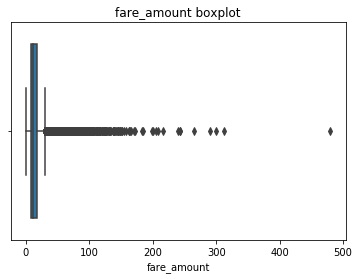

In [20]:
ax = sns.boxplot(x="fare_amount", data=data)
ax.set_title("fare_amount boxplot")
plt.show()

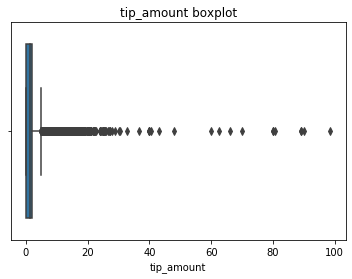

In [21]:
ax = sns.boxplot(x="tip_amount", data=data)
ax.set_title("tip_amount boxplot")
plt.show()

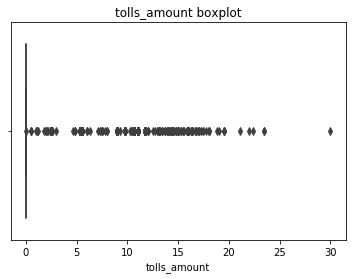

In [22]:
ax = sns.boxplot(x="tolls_amount", data=data)
ax.set_title("tolls_amount boxplot")
plt.show()

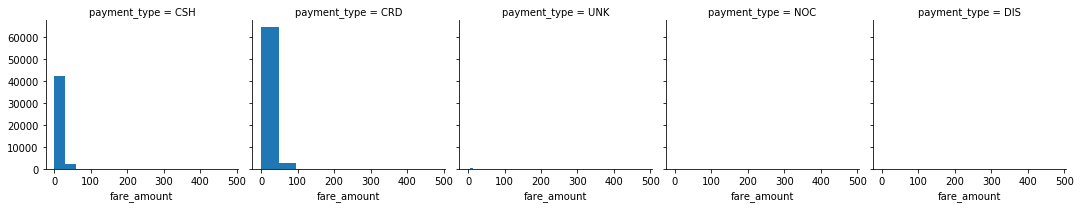

In [23]:
g = sns.FacetGrid(data = data, col = 'payment_type', palette = 'bright');
g.map(plt.hist,'fare_amount')

- More than 60% of the passengers have used credit card for paying their fare charges.
- Around 40% of the passengers made payments in cash.

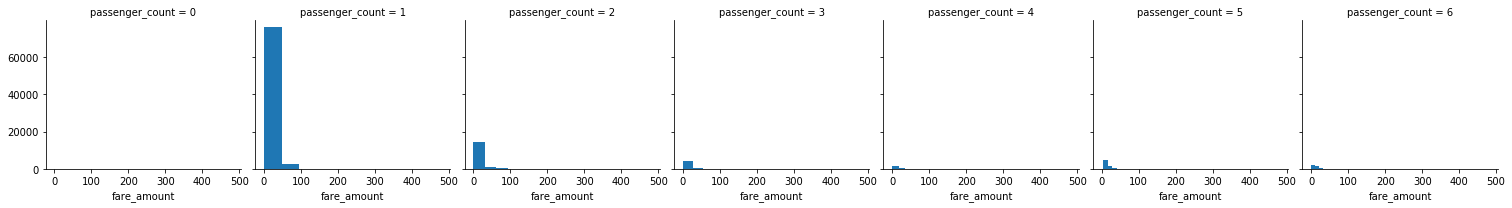

In [24]:
g = sns.FacetGrid(data = data, col = 'passenger_count', palette = 'bright');
g.map(plt.hist,'fare_amount')

## Feature Engineering

In [26]:
data['travel_time'] = (data['dropoff_datetime'] - data['pickup_datetime']).abs() 

In [27]:
data['travel_time_hrs'] = data['travel_time'] / np.timedelta64(1,'h')

In [28]:
data.drop(['dropoff_datetime', 'pickup_datetime', 'travel_time'], axis = 1, inplace = True)

In [29]:
data.shape

(112619, 16)

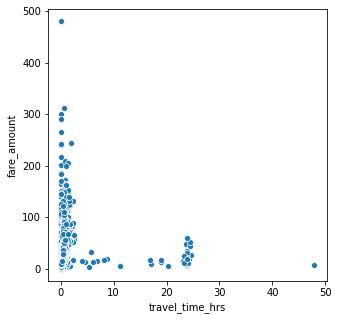

In [30]:
f,ax=plt.subplots(figsize=(5,5))
sns.scatterplot(x = data['travel_time_hrs'], y = data['fare_amount'])

- Ideally, there should have been linear relationship between travel time in hours and fare_amount.
- However, we can clearly see that fare_amount is not dependent on travel time hours.

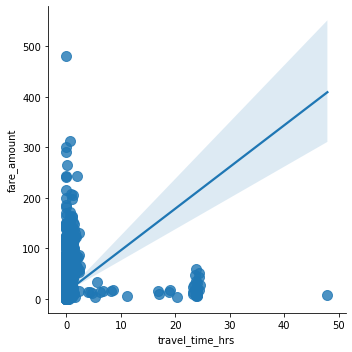

In [31]:
sns.lmplot('travel_time_hrs', 'fare_amount', data, 
             truncate=True, scatter_kws={"s": 100})

###  Haversine Formula

- The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and      latitudes

- Calculating Distance between pickup location and drop location from Location Co-ordinates.

- We will use Haversine Formula to calculate the distance (in km) between two latitudes and longitudes.


In [32]:
import math
from math import *
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    
    Radius = 6371 # km
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)

    a = np.sin(dLat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dLon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    km = Radius * c
    
    return km

In [33]:
data['haversine_dist'] = haversine(data['pickup_latitude'],
                                   data['pickup_longitude'],
                                   data['dropoff_latitude'],
                                   data['dropoff_longitude']) 

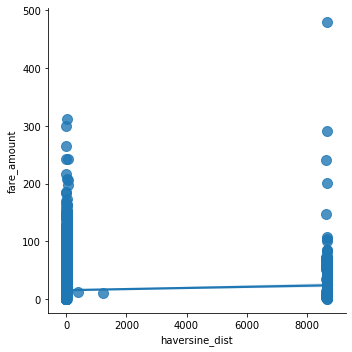

In [34]:
sns.lmplot('haversine_dist', 'fare_amount', data, 
             truncate=True, scatter_kws={"s": 100})

- If haversine_dist increases fare_amount should increase. 
- However, from above plot we can dervive that fare_amount is below 300 dollars even for haversine_dist above 8000km 
- Lets skim the data once by filtering haversine_dist feature above 8000km.

In [35]:
data[(data.haversine_dist >= 60) & (data.travel_time_hrs == 0.00)]

,vendor_id,new_user,tolls_amount,tip_amount,mta_tax,passenger_count,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,surcharge,fare_amount,travel_time_hrs,haversine_dist
TID,,,,,,,,,,,,,,,,,
AIX000369724,DST000401,NO,0.00,0.0,0.5,1,-73.947297,40.715747,1,N,0.0,0.0,CSH,0.0,21.00,0.0,8662.265439
AIX000369740,DST000401,NO,0.00,0.0,0.5,1,-73.994849,40.749980,1,N,0.0,0.0,CSH,1.0,4.00,0.0,8666.904907
AIX000398455,DST000401,NO,0.00,0.0,0.5,1,-73.945742,40.807550,1,N,0.0,0.0,CSH,0.5,12.50,0.0,8664.021627
AIX000404440,DST000401,NO,0.00,0.0,0.5,1,-73.987560,40.765447,1,N,0.0,0.0,CSH,0.0,3.00,0.0,8666.618112
AIX000412402,DST000532,NO,5.33,5.0,0.5,3,-74.005952,40.748762,2,N,0.0,0.0,CRD,0.0,62.83,0.0,8667.799323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AIX0001875012,DST000481,NO,0.00,0.0,0.5,1,-73.980865,40.764008,1,N,0.0,0.0,CSH,0.0,6.30,0.0,8666.034471
AIX0001881005,DST000481,NO,0.00,0.0,0.5,2,-73.991570,40.749908,1,N,0.0,0.0,CSH,0.0,12.80,0.0,8666.631908
AIX0001886270,DST000481,NO,0.00,0.0,0.5,1,-73.994736,40.750561,1,N,0.0,0.0,CSH,0.0,14.80,0.0,8666.907413


- This highlighted that we have zero values for dropoff_longitude and dropoff_latitude. we need to dropoff these rows as well.
- Now we will take filter on dropoff_longitude and dropoff_latitude columns that are having zero values.

In [36]:
data[(data.dropoff_longitude == 0.000) & (data.dropoff_latitude == 0.000)]

,vendor_id,new_user,tolls_amount,tip_amount,mta_tax,passenger_count,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,surcharge,fare_amount,travel_time_hrs,haversine_dist
TID,,,,,,,,,,,,,,,,,
AIX000345469,DST000401,NO,0.00,0.00,0.5,4,0.000000,0.000000,1,N,0.0,0.0,CSH,1.0,10.50,0.205278,0.000000
AIX000345669,DST000532,NO,0.00,0.00,0.5,1,-74.003937,40.737507,5,N,0.0,0.0,CRD,0.0,20.50,0.016667,8667.402314
AIX000345963,DST000401,NO,0.00,1.56,0.5,1,0.000000,0.000000,1,N,0.0,0.0,CRD,0.0,13.80,0.201944,0.000000
AIX000347467,DST000532,NO,0.00,2.30,0.5,1,0.000000,0.000000,1,N,0.0,0.0,CRD,0.0,14.30,0.250000,0.000000
AIX000347709,DST000532,NO,5.33,5.00,0.5,1,0.000000,0.000000,2,N,0.0,0.0,CRD,0.0,62.83,0.466667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AIX0002000722,DST000481,NO,0.00,0.00,0.5,1,0.000000,0.000000,1,N,0.0,0.0,CSH,0.0,5.80,0.069167,0.000000
AIX0002000767,DST000481,NO,0.00,1.85,0.5,1,0.000000,0.000000,1,N,0.0,0.0,CRD,0.0,11.15,0.159444,0.000000
AIX0002000822,DST000481,NO,0.00,0.00,0.5,5,0.000000,0.000000,2,N,0.0,0.0,CSH,0.0,52.80,0.510833,0.000000


In [37]:
data = data[~((data.dropoff_longitude == 0.000) & (data.dropoff_latitude == 0.000))]

In [38]:
data.shape

(110566, 17)

In [39]:
data[(data.pickup_longitude == 0.0) & (data.pickup_latitude == 0.0)]

,vendor_id,new_user,tolls_amount,tip_amount,mta_tax,passenger_count,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,surcharge,fare_amount,travel_time_hrs,haversine_dist
TID,,,,,,,,,,,,,,,,,
AIX000350453,DST000401,NO,0.00,0.00,0.5,1,0.0,0.0,1,N,-73.983792,40.754702,CSH,0.0,10.00,0.232500,8666.086121
AIX000388442,DST000401,NO,0.00,1.56,0.5,2,0.0,0.0,1,N,-73.999712,40.714042,CRD,0.5,16.00,0.316667,8666.572594
AIX000479906,DST000401,NO,0.00,0.00,0.5,1,0.0,0.0,1,N,-73.988910,40.695085,CSH,0.0,10.00,0.145556,8665.289955
AIX000512586,DST000401,NO,0.00,1.90,0.5,1,0.0,0.0,1,N,-73.974668,40.752442,CRD,0.5,11.40,0.173611,8665.284437
AIX000523518,DST000401,NO,0.00,5.10,0.5,1,0.0,0.0,1,N,-73.991618,40.726274,CRD,0.0,30.60,0.005833,8666.152269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AIX0001991882,DST000481,NO,0.00,3.75,0.5,2,0.0,0.0,1,N,-73.970215,40.785683,CRD,0.0,13.05,0.184444,8665.597327
AIX0001992379,DST000481,NO,0.00,0.00,0.5,1,0.0,0.0,1,N,-73.975403,40.744354,CSH,0.0,10.30,0.223333,8665.179565
AIX0001993710,DST000481,NO,5.54,0.00,0.5,1,0.0,0.0,1,N,-73.969780,40.784672,CSH,0.5,33.84,0.371667,8665.540608


In [40]:
data = data[~((data.pickup_longitude == 0.0) & (data.pickup_latitude == 0.0))]

In [41]:
data.shape

(110370, 17)

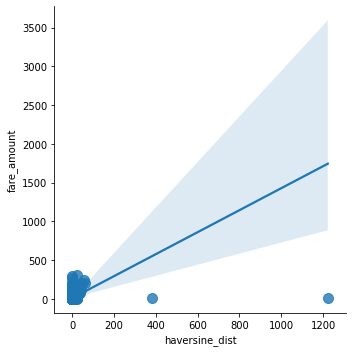

In [42]:
sns.lmplot('haversine_dist', 'fare_amount', data, 
             truncate=True, scatter_kws={"s": 100})

In [43]:
data[(data.haversine_dist >= 60)]

,vendor_id,new_user,tolls_amount,tip_amount,mta_tax,passenger_count,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,surcharge,fare_amount,travel_time_hrs,haversine_dist
TID,,,,,,,,,,,,,,,,,
AIX0001071884,DST000401,NO,0.0,0.0,0.5,2,-81.169787,50.514841,1,N,-73.992595,40.721399,CSH,0.5,10.0,0.169167,1222.340445
AIX0001792537,DST000481,NO,0.0,0.0,0.5,1,-73.972717,40.758434,1,N,-78.107147,42.253078,CSH,0.0,12.8,0.323611,382.241378


- upon checking, dropoff_latitude and dropoff_longitude on Google map we see that it belongs to newyork city whereas the
  pickup_longitude and pickup_latitude belongs to Onatrio, Canada for TID AIX0001071884.
- dropoff_latitude and dropoff_longitude for TID AIX0001792537 belongs to Allegany county in New York which is close to Canada Border and pickup_longitude and pickup_latitude belongs to newyork city.
- Fare_amount for the above TIDs are incorrect so we are dropping these 2 rows from our data.

In [44]:
data = data[~(data.haversine_dist >= 60)]

In [45]:
data.shape

(110368, 17)

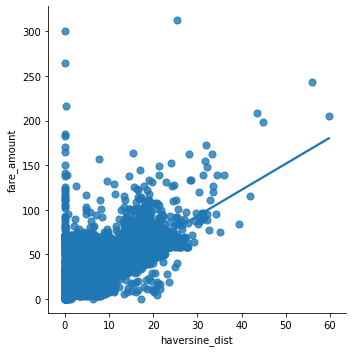

In [46]:
sns.lmplot('haversine_dist', 'fare_amount', data, 
             truncate=True, scatter_kws={"s": 50})

- Post cleaning data, now we can see the positive correlation between the dependent (fare_amount) and the independent
  variable haversine_dist.

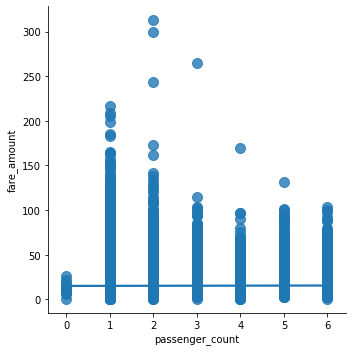

In [47]:
sns.lmplot('passenger_count', 'fare_amount', data, 
             truncate=True, scatter_kws={"s": 100})

In [48]:
data[data.passenger_count == 0]

,vendor_id,new_user,tolls_amount,tip_amount,mta_tax,passenger_count,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,surcharge,fare_amount,travel_time_hrs,haversine_dist
TID,,,,,,,,,,,,,,,,,
AIX0001067048,DST000401,NO,0.0,3.00,0.0,0,-73.963680,40.765813,5,N,-73.963030,40.766537,CRD,0.0,18.00,0.008611,0.097353
AIX0001348546,DST000401,NO,0.0,0.00,0.5,0,-73.862602,40.768838,1,N,-73.888244,40.753577,CSH,0.0,13.00,0.263056,2.746583
AIX0001503279,DST000481,NO,0.0,0.00,0.5,0,-73.990829,40.751122,1,N,-73.955200,40.768822,CSH,0.5,15.30,0.288333,3.588718
AIX0001512945,DST000481,NO,0.0,5.20,0.5,0,-73.982559,40.692436,1,N,-73.968338,40.752464,CRD,0.0,26.00,0.249444,6.781554
AIX0001515044,DST000481,NO,0.0,1.56,0.5,0,-73.956978,40.768524,1,N,-73.975426,40.778534,CRD,0.5,10.30,0.126389,1.911035
AIX0001518255,DST000481,NO,0.0,0.00,0.5,0,-73.975723,40.789295,1,N,-73.940903,40.829243,CSH,0.5,21.30,0.505278,5.321587
AIX0001650415,DST000481,NO,0.0,0.00,0.5,0,-74.004707,40.741631,1,N,-73.971741,40.762714,CSH,0.5,13.80,0.236111,3.634230
AIX0001694510,DST000481,NO,0.0,1.25,0.5,0,-73.966064,40.773224,1,N,-73.972816,40.764366,CRD,0.0,7.55,0.101389,1.137284
AIX0001713223,DST000481,NO,0.0,1.50,0.5,0,-74.002014,40.739529,1,N,-74.007286,40.705086,CRD,0.5,13.30,0.157778,3.855559


In [49]:
data = data[~(data.passenger_count == 0)]

In [50]:
data.shape

(110352, 17)

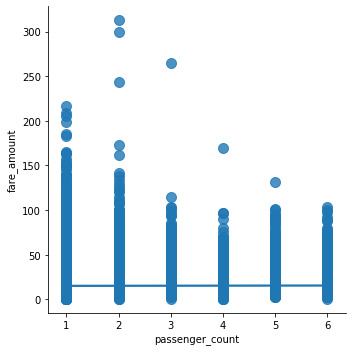

In [51]:
sns.lmplot('passenger_count', 'fare_amount', data, 
             truncate=True, scatter_kws={"s": 100})

In [52]:
data.head()

,vendor_id,new_user,tolls_amount,tip_amount,mta_tax,passenger_count,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,surcharge,fare_amount,travel_time_hrs,haversine_dist
TID,,,,,,,,,,,,,,,,,
AIX000345005,DST000401,NO,0.0,0.00,0.5,1,-74.004657,40.707434,1,N,-73.999369,40.721517,CSH,0.0,10.0,0.228333,1.628146
AIX000345019,DST000401,NO,0.0,0.00,0.5,1,-73.995108,40.755005,1,N,-73.989492,40.745640,CSH,0.5,6.5,0.073611,1.143761
AIX000345026,DST000401,NO,0.0,1.56,0.5,1,-73.969530,40.790267,1,N,-73.987282,40.766865,CRD,0.0,10.6,0.150000,3.000934
AIX000345034,DST000401,NO,0.0,1.70,0.5,1,-73.977336,40.742819,1,N,-73.993617,40.721326,CRD,0.5,10.2,0.092778,2.755653
AIX000345052,DST000401,NO,0.0,1.00,0.5,1,-73.998653,40.715607,1,N,-73.988385,40.723130,CRD,0.5,8.5,0.091389,1.203574


In [53]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tolls_amount,110352.0,0.273544,1.282257,0.000000,0.000000,0.000000,0.000000,30.000000
tip_amount,110352.0,1.553036,2.221659,0.000000,0.000000,1.260000,2.000000,98.550000
mta_tax,110352.0,0.498215,0.030795,-0.500000,0.500000,0.500000,0.500000,0.500000
passenger_count,110352.0,1.725170,1.389595,1.000000,1.000000,1.000000,2.000000,6.000000
pickup_longitude,110352.0,-73.974022,0.260229,-99.083115,-73.992124,-73.981995,-73.968086,0.000000
pickup_latitude,110352.0,40.750213,0.166384,-13.551884,40.736758,40.753455,40.767521,41.465905
rate_code,110352.0,1.030629,0.244197,0.000000,1.000000,1.000000,1.000000,6.000000
dropoff_longitude,110352.0,-73.973508,0.260045,-99.083115,-73.991563,-73.980435,-73.964185,0.000000
dropoff_latitude,110352.0,40.750763,0.167115,-13.551884,40.735217,40.753730,40.768568,41.465904
surcharge,110352.0,0.329070,0.353723,-1.000000,0.000000,0.500000,0.500000,2.500000


In [54]:
data.isnull().sum()

vendor_id             0
new_user              0
tolls_amount          0
tip_amount            0
mta_tax               0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
rate_code             0
store_and_fwd_flag    0
dropoff_longitude     0
dropoff_latitude      0
payment_type          0
surcharge             0
fare_amount           0
travel_time_hrs       0
haversine_dist        0
dtype: int64

In [55]:
data.drop(['dropoff_latitude', 'pickup_latitude', 'dropoff_longitude', 'pickup_longitude'],
          axis = 1, inplace = True)

In [56]:
data.drop(['vendor_id'], axis = 1, inplace = True)

In [57]:
data.shape

(110352, 12)

In [58]:
data.travel_time_hrs.agg(['mean', 'min', 'max', 'median'])

mean       0.229705
min        0.000000
max       47.912222
median     0.181667
Name: travel_time_hrs, dtype: float64

In [59]:
data['travel_time_hrs'].unique

<bound method Series.unique of TID
AIX000345005     0.228333
AIX000345019     0.073611
AIX000345026     0.150000
AIX000345034     0.092778
AIX000345052     0.091389
                   ...   
AIX0002003050    0.185833
AIX0002003055    0.167222
AIX0002003072    0.891944
AIX0002003087    0.094722
AIX0002003095    0.185278
Name: travel_time_hrs, Length: 110352, dtype: float64>

In [60]:
data.describe().T    # Only Numerical features statistics

,count,mean,std,min,25%,50%,75%,max
tolls_amount,110352.0,0.273544,1.282257,0.0,0.000000,0.000000,0.000000,30.000000
tip_amount,110352.0,1.553036,2.221659,0.0,0.000000,1.260000,2.000000,98.550000
mta_tax,110352.0,0.498215,0.030795,-0.5,0.500000,0.500000,0.500000,0.500000
passenger_count,110352.0,1.725170,1.389595,1.0,1.000000,1.000000,2.000000,6.000000
rate_code,110352.0,1.030629,0.244197,0.0,1.000000,1.000000,1.000000,6.000000
surcharge,110352.0,0.329070,0.353723,-1.0,0.000000,0.500000,0.500000,2.500000
fare_amount,110352.0,15.266761,12.442520,0.0,8.300000,11.500000,17.000000,312.500000
travel_time_hrs,110352.0,0.229705,0.458129,0.0,0.108056,0.181667,0.283333,47.912222
haversine_dist,110352.0,3.383266,3.735084,0.0,1.252498,2.141701,3.916113,59.748047


In [61]:
data.isnull().sum()

new_user              0
tolls_amount          0
tip_amount            0
mta_tax               0
passenger_count       0
rate_code             0
store_and_fwd_flag    0
payment_type          0
surcharge             0
fare_amount           0
travel_time_hrs       0
haversine_dist        0
dtype: int64

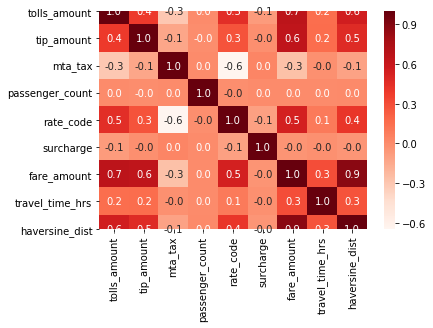

In [62]:
sns.heatmap(data.corr(), annot = True, cmap = "Reds", fmt = ".1f")

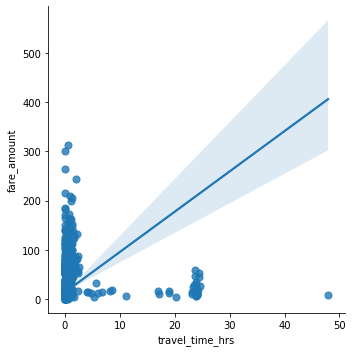

In [63]:
sns.lmplot('travel_time_hrs', 'fare_amount', data, 
             truncate=True, scatter_kws={"s": 50})

In [64]:
data[(data.travel_time_hrs >= 2) & (data.fare_amount <= 16)]

,new_user,tolls_amount,tip_amount,mta_tax,passenger_count,rate_code,store_and_fwd_flag,payment_type,surcharge,fare_amount,travel_time_hrs,haversine_dist
TID,,,,,,,,,,,,
AIX000517204,NO,0.0,0.00,0.5,1,1,N,CSH,0.5,3.50,5.271944,2.037550
AIX0001349534,NO,0.0,0.00,0.5,1,1,N,CSH,0.5,13.50,4.300278,6.583414
AIX0001496144,NO,0.0,0.00,0.5,1,1,N,CSH,0.0,9.30,17.070000,3.011340
AIX0001509889,NO,0.0,0.00,0.5,1,1,N,CSH,1.0,5.30,11.191667,4.169252
AIX0001516304,NO,0.0,0.00,0.5,1,1,N,CSH,0.0,8.80,23.881389,2.161156
AIX0001516691,NO,0.0,0.00,0.5,1,1,N,CSH,0.0,7.80,23.915833,1.411549
AIX0001530804,NO,0.0,0.00,0.5,5,1,N,CSH,1.0,11.80,4.678889,4.047081
AIX0001541884,NO,0.0,0.00,0.5,1,1,N,CSH,0.0,8.80,23.796389,1.991466
AIX0001567468,NO,0.0,1.30,0.5,2,1,N,CRD,0.5,8.60,23.982500,1.151945


- for average travel_time_hrs of 0.229699 hours the mean fare_amount is 15.266438 dollars.
- we will drop these rows as the fare amount is incorrectly charged.

In [65]:
data = data[~((data.travel_time_hrs >= 2) & (data.fare_amount <= 16))]

In [66]:
data.shape

(110327, 12)

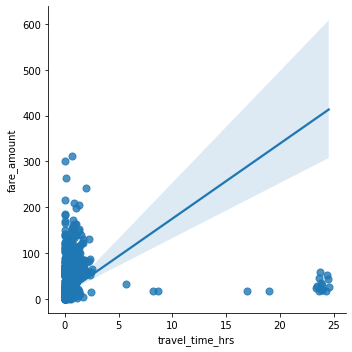

In [67]:
sns.lmplot('travel_time_hrs', 'fare_amount', data, 
             truncate=True, scatter_kws={"s": 50})

In [68]:
data[(data.fare_amount >= 100)]

,new_user,tolls_amount,tip_amount,mta_tax,passenger_count,rate_code,store_and_fwd_flag,payment_type,surcharge,fare_amount,travel_time_hrs,haversine_dist
TID,,,,,,,,,,,,
AIX000365073,NO,13.75,28.75,0.0,2,5,N,CRD,0.0,172.50,0.753333,31.841502
AIX000398124,NO,0.00,0.00,0.0,1,5,N,CRD,0.0,120.00,0.014444,0.000000
AIX000400794,NO,0.00,0.00,0.5,1,5,N,CRD,0.0,100.50,0.450000,25.617007
AIX000419623,NO,16.33,10.00,0.5,1,5,N,CRD,0.0,126.83,0.616667,2.604349
AIX000429528,NO,11.00,20.12,0.0,1,3,N,CRD,0.0,100.62,0.533333,14.686152
...,...,...,...,...,...,...,...,...,...,...,...,...
AIX0001865666,NO,18.79,0.00,0.0,1,5,N,CSH,0.0,139.09,1.471111,21.344037
AIX0001933577,NO,5.54,27.17,0.0,1,5,N,CRD,0.0,163.01,0.978333,28.138593
AIX0001960239,NO,19.50,17.95,0.0,2,3,N,CRD,0.5,107.75,0.666944,19.720453


In [69]:
data[(data.travel_time_hrs >= 10) & (data.fare_amount <= 100)]

,new_user,tolls_amount,tip_amount,mta_tax,passenger_count,rate_code,store_and_fwd_flag,payment_type,surcharge,fare_amount,travel_time_hrs,haversine_dist
TID,,,,,,,,,,,,
AIX0001501222,NO,0.00,0.00,0.5,5,1,N,CSH,0.5,28.30,23.495556,10.671251
AIX0001546128,NO,0.00,0.00,0.5,5,1,N,CSH,1.0,46.80,23.636111,16.561129
AIX0001584041,NO,5.33,1.56,0.5,3,1,N,CRD,0.0,34.79,23.865833,9.249608
AIX0001615078,NO,0.00,6.00,0.5,2,1,N,CRD,0.5,43.80,24.436667,13.032836
AIX0001639079,NO,0.00,1.00,0.5,1,1,N,CRD,0.5,17.80,24.288889,5.870181
AIX0001679921,NO,0.00,2.44,0.5,1,1,N,CRD,0.5,18.74,23.923889,3.153779
AIX0001703779,NO,0.00,0.00,0.5,1,1,N,CSH,0.5,26.80,24.543611,6.582796
AIX0001708788,NO,0.00,10.45,0.5,1,1,N,CRD,0.5,52.25,24.362500,15.872230
AIX0001751770,NO,0.00,2.83,0.5,1,1,N,CRD,0.5,31.13,23.904167,8.669825


In [70]:
data = data[~((data.travel_time_hrs >= 10) & (data.fare_amount <= 100))] 

In [71]:
data.shape

(110311, 12)

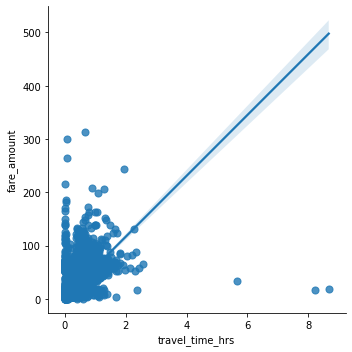

In [72]:
sns.lmplot('travel_time_hrs', 'fare_amount', data, 
             truncate=True, scatter_kws={"s": 50})

In [73]:
data[(data.travel_time_hrs >= 4)]

,new_user,tolls_amount,tip_amount,mta_tax,passenger_count,rate_code,store_and_fwd_flag,payment_type,surcharge,fare_amount,travel_time_hrs,haversine_dist
TID,,,,,,,,,,,,
AIX0001523618,NO,0.00,0.00,0.5,1,1,N,CSH,0.0,17.80,8.672778,3.860456
AIX0001735473,NO,0.00,1.56,0.5,1,1,N,CRD,0.0,16.44,8.222778,3.130077
AIX0001939953,NO,5.54,0.00,0.5,1,1,N,CSH,0.5,32.84,5.663333,11.725376


In [74]:
data = data[~(data.travel_time_hrs >= 4)]

In [75]:
data.shape

(110308, 12)

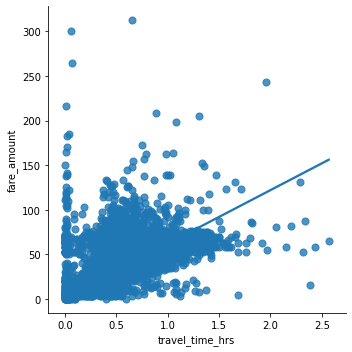

In [76]:
sns.lmplot('travel_time_hrs', 'fare_amount', data, 
             truncate=True, scatter_kws={"s": 50})

In [77]:
data[(data.travel_time_hrs >= 1) & (data.fare_amount <= 15)]

,new_user,tolls_amount,tip_amount,mta_tax,passenger_count,rate_code,store_and_fwd_flag,payment_type,surcharge,fare_amount,travel_time_hrs,haversine_dist
TID,,,,,,,,,,,,
AIX000395667,NO,0.0,1.90,0.5,2,1,N,CRD,1.0,11.40,1.076944,1.177410
AIX000442800,NO,0.0,0.00,0.5,1,1,N,NOC,0.0,3.00,1.122222,0.002950
AIX000571338,NO,0.0,1.62,0.5,1,1,N,CRD,0.0,8.12,1.300000,2.654551
AIX000778394,NO,0.0,1.00,0.5,1,1,N,CRD,0.5,8.00,1.124722,0.548636
AIX000831294,NO,0.0,0.00,0.5,1,1,N,CSH,0.5,8.00,1.060556,4.738279
AIX0001004987,NO,0.0,1.56,0.5,1,1,N,CSH,0.5,10.00,1.371944,1.620692
AIX0001017330,NO,0.0,0.00,0.5,1,1,Y,DIS,0.5,4.00,1.686111,0.174911
AIX0001737809,NO,0.0,0.00,0.5,1,1,N,CSH,0.0,5.80,1.076389,0.586910
AIX0001762899,NO,0.0,1.00,0.5,1,1,N,CRD,0.5,9.30,1.262778,3.697789


In [78]:
data = data[~((data.travel_time_hrs >= 1) & (data.fare_amount <= 15))] 

In [79]:
data.shape

(110298, 12)

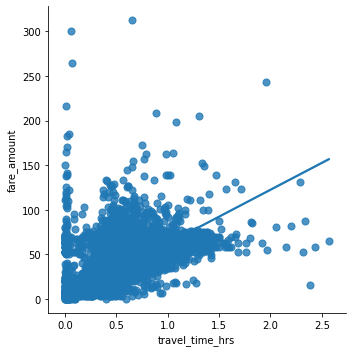

In [80]:
sns.lmplot('travel_time_hrs', 'fare_amount', data, 
             truncate=True, scatter_kws={"s": 50})

In [81]:
data[(data.travel_time_hrs <= 0.000)]

,new_user,tolls_amount,tip_amount,mta_tax,passenger_count,rate_code,store_and_fwd_flag,payment_type,surcharge,fare_amount,travel_time_hrs,haversine_dist
TID,,,,,,,,,,,,
AIX000364768,NO,0.00,0.00,0.5,1,1,N,CSH,0.5,3.50,0.0,0.008415
AIX000374102,NO,0.00,0.00,0.5,1,1,N,CSH,0.0,3.50,0.0,0.178369
AIX000374759,NO,0.00,0.90,0.5,1,1,N,CRD,0.0,4.40,0.0,0.369305
AIX000412201,NO,5.33,14.33,0.5,1,2,N,CRD,0.0,72.16,0.0,3.968019
AIX000452060,NO,5.33,0.00,0.5,2,2,N,CRD,0.0,57.83,0.0,2.280103
...,...,...,...,...,...,...,...,...,...,...,...,...
AIX0001428746,NO,0.00,1.00,0.5,1,1,N,CRD,0.5,4.50,0.0,0.232276
AIX0001429571,NO,0.00,0.00,0.5,3,2,N,CSH,0.0,52.50,0.0,0.026988
AIX0001476651,NO,0.00,0.00,0.5,1,1,N,CSH,0.5,3.50,0.0,0.007752


In [82]:
data = data[~(data.travel_time_hrs <= 0.000)]

In [83]:
data.shape

(110221, 12)

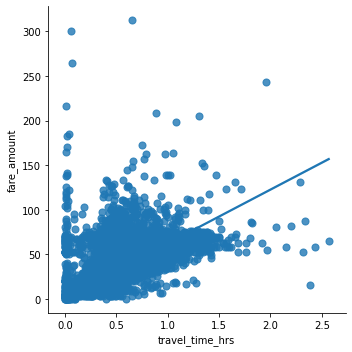

In [84]:
sns.lmplot('travel_time_hrs', 'fare_amount', data, 
             truncate=True, scatter_kws={"s": 50})

In [85]:
data[(data.travel_time_hrs <= 1) & (data.fare_amount >= 100)]

,new_user,tolls_amount,tip_amount,mta_tax,passenger_count,rate_code,store_and_fwd_flag,payment_type,surcharge,fare_amount,travel_time_hrs,haversine_dist
TID,,,,,,,,,,,,
AIX000365073,NO,13.75,28.75,0.0,2,5,N,CRD,0.0,172.50,0.753333,31.841502
AIX000398124,NO,0.00,0.00,0.0,1,5,N,CRD,0.0,120.00,0.014444,0.000000
AIX000400794,NO,0.00,0.00,0.5,1,5,N,CRD,0.0,100.50,0.450000,25.617007
AIX000419623,NO,16.33,10.00,0.5,1,5,N,CRD,0.0,126.83,0.616667,2.604349
AIX000429528,NO,11.00,20.12,0.0,1,3,N,CRD,0.0,100.62,0.533333,14.686152
...,...,...,...,...,...,...,...,...,...,...,...,...
AIX0001860142,NO,0.00,1.56,0.0,1,5,N,CRD,0.0,122.16,0.373611,16.456099
AIX0001933577,NO,5.54,27.17,0.0,1,5,N,CRD,0.0,163.01,0.978333,28.138593
AIX0001960239,NO,19.50,17.95,0.0,2,3,N,CRD,0.5,107.75,0.666944,19.720453


In [86]:
data = data[~((data.travel_time_hrs <= 1) & (data.fare_amount >= 100))]

In [87]:
data.shape

(110131, 12)

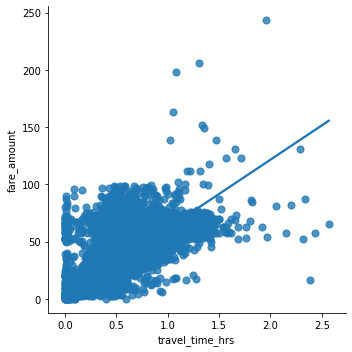

In [88]:
sns.lmplot('travel_time_hrs', 'fare_amount', data, 
             truncate=True, scatter_kws={"s": 50})

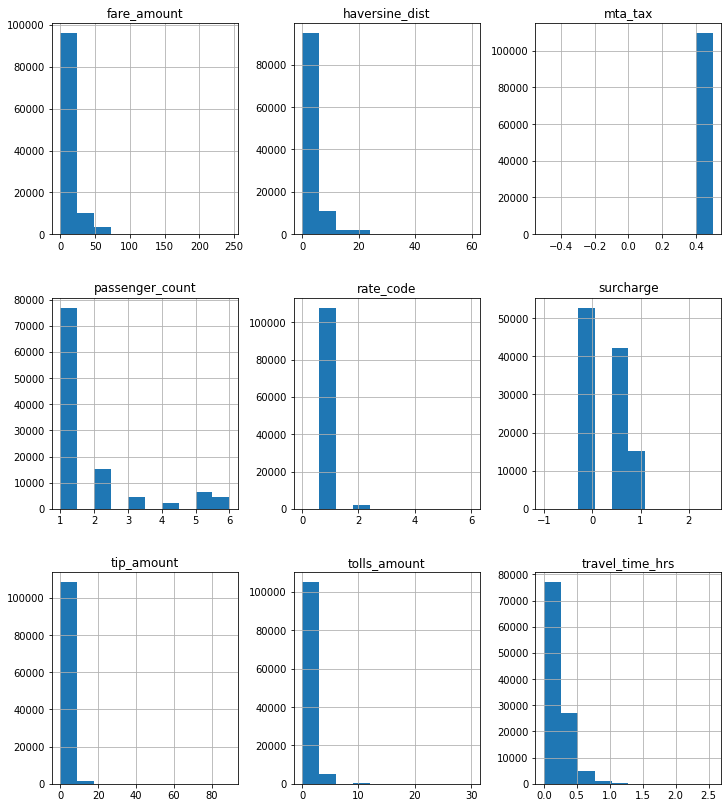

In [89]:
fig = plt.figure(figsize = (12,14))
ax = fig.gca()
data.hist(ax=ax)
plt.show()

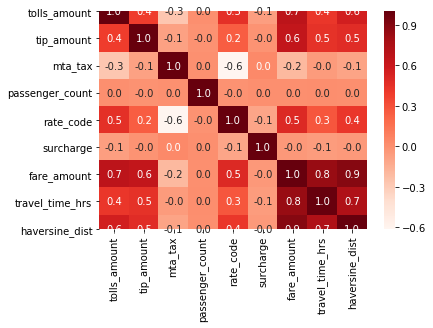

In [90]:
sns.heatmap(data.corr(), annot = True, cmap = "Reds", fmt = ".1f")

In [91]:
data.dtypes

new_user               object
tolls_amount          float64
tip_amount            float64
mta_tax               float64
passenger_count         int64
rate_code               int64
store_and_fwd_flag     object
payment_type           object
surcharge             float64
fare_amount           float64
travel_time_hrs       float64
haversine_dist        float64
dtype: object

In [92]:
### Lets check the Skewness of Target feature 'fair_amount'

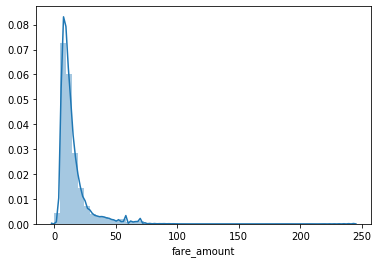

In [93]:
sns.distplot(data['fare_amount'])

In [94]:
print ("The skewness of fare_amount is {}".format(data['fare_amount'].skew())) 

The skewness of fare_amount is 2.824167223571681


- We see that the target variable 'fare_amount' has a right-skewed distribution.

- We'll need to log transform this variable so that it becomes normally distributed. 

- A normally distributed (or close to normal) target variable helps in better modeling the relationship between 
  target and independent variables. 

- In addition, linear algorithms assume constant variance in the error term. 


In [95]:
category_cols = ['new_user', 'store_and_fwd_flag', 'payment_type']

In [96]:
from sklearn.preprocessing import StandardScaler

###  Train-Validation Split

In [97]:
train, valid = train_test_split(data, test_size = 0.3, random_state = 1234)

In [98]:
print("Shape of training set:", train.shape)
print("Shape of validation set:", valid.shape)

Shape of training set: (77091, 12)
Shape of validation set: (33040, 12)


In [114]:
x_train = train.drop('fare_amount', axis = 1)
y_train = train['fare_amount']

x_valid = valid.drop('fare_amount', axis = 1)
y_valid = valid['fare_amount']


In [115]:
print("Shape of training set:", x_train.shape)
print("Shape of validation set:", x_valid.shape)

Shape of training set: (77091, 11)
Shape of validation set: (33040, 11)


In [116]:
x_train = pd.get_dummies(x_train, columns = category_cols, drop_first = True)
x_valid = pd.get_dummies(x_valid, columns = category_cols, drop_first = True) 

In [117]:
print("Shape of training set:", x_train.shape)
print("Shape of validation set:", x_valid.shape)


Shape of training set: (77091, 14)
Shape of validation set: (33040, 14)


In [118]:
print(y_train.shape)
print(y_valid.shape)

(77091,)
(33040,)


In [119]:
x_train.head()

,tolls_amount,tip_amount,mta_tax,passenger_count,rate_code,surcharge,travel_time_hrs,haversine_dist,new_user_YES,store_and_fwd_flag_Y,payment_type_CSH,payment_type_DIS,payment_type_NOC,payment_type_UNK
TID,,,,,,,,,,,,,,
AIX000878977,0.0,1.00,0.5,3,1,0.5,0.200000,2.976248,0,0,0,0,0,0
AIX0001816203,0.0,1.00,0.5,3,1,0.0,0.112222,1.687513,0,0,0,0,0,0
AIX000685552,0.0,0.80,0.5,1,1,0.0,0.033333,0.748610,0,0,0,0,0,0
AIX0001842463,0.0,1.56,0.5,1,1,0.0,0.558333,2.794227,0,0,1,0,0,0
AIX0001809843,0.0,0.00,0.5,2,1,1.0,0.394444,4.407955,0,0,1,0,0,0


### Feature Scaling

In [120]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)

x_valid = sc.transform(x_valid) 


In [121]:
x_train[1]

array([-0.21382727, -0.25455559,  0.05168026,  0.91692039, -0.12378102,
       -0.93291822, -0.65597861, -0.45734408, -0.0108055 , -0.09461532,
       -0.81388655, -0.03014702, -0.04957493, -0.05917433])

In [122]:
y_train[1]

8.8


### Modelling

### Linear Regression

In [123]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()

LR.fit(x_train,y_train)

LR_pred_train = LR.predict(x_train)

LR_pred_valid = LR.predict(x_valid)


In [124]:
LR_pred_valid[1]

15.512768445511057

In [125]:
y_valid[1]

15.36

### Predictions (On Valid)

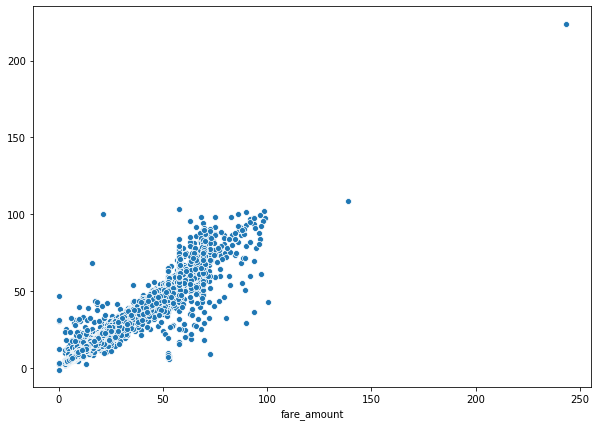

In [139]:
f,ax=plt.subplots(figsize=(10,7))
sns.scatterplot(x = y_valid, y = LR_pred_valid);

### Residual Histogram (On valid)

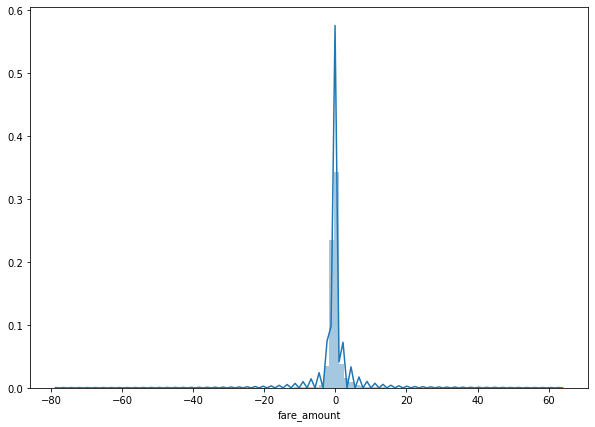

In [126]:
f,ax=plt.subplots(figsize=(10,7))
sns.distplot((y_valid-LR_pred_valid),bins=100)

In [127]:
from sklearn import metrics

Here are three common evaluation metrics for regression problems:

Mean Absolute Error (MAE) is the mean of the absolute value of the errors:

1n∑i=1n|yi−y^i|
 
Mean Squared Error (MSE) is the mean of the squared errors:

1n∑i=1n(yi−y^i)2
 
Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:

1n∑i=1n(yi−y^i)2−−−−−−−−−−−−√
 
Comparing these metrics:

MAE is the easiest to understand, because it's the average error.
MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.
All of these are loss functions, because we want to minimize them.

We will be using RMSE loss function to evaluate our predictions.

In [128]:
print('Train RMSE:', np.sqrt(metrics.mean_squared_error(y_train, LR_pred_train)))

print('Validation RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, LR_pred_valid))) 

Train RMSE: 2.5511235386089033
Validation RMSE: 2.728019765370912


In [129]:
LR_pred_valid

array([22.8168543 , 15.51276845,  4.07568731, ..., 22.90719244,
       11.40346616,  6.6403428 ])

In [130]:
LR_pred_train

array([13.08258759,  8.73979748,  5.29857355, ..., 16.30689586,
       64.73968398,  7.95710696])

In [131]:
LR_pred = np.concatenate([LR_pred_train, LR_pred_valid])

In [132]:
LR_pred

array([13.08258759,  8.73979748,  5.29857355, ..., 22.90719244,
       11.40346616,  6.6403428 ])

## KNN

In [133]:
from sklearn.neighbors import KNeighborsRegressor

KNN = KNeighborsRegressor()

KNN.fit(x_train, y_train)

KNN_pred_train = KNN.predict(x_train)

KNN_pred_valid = KNN.predict(x_valid)

In [134]:
print('Train RMSE:', np.sqrt(metrics.mean_squared_error(y_train, KNN_pred_train)))
print('validation RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, KNN_pred_valid)))

Train RMSE: 1.6957270154290758
validation RMSE: 2.2509363589156894


In [135]:
KNN_pred_train

array([12.3  ,  8.48 ,  5.3  , ..., 15.676, 71.572,  8.26 ])

In [136]:
KNN_pred_valid

array([22.23 , 14.72 ,  4.1  , ..., 22.352, 11.86 ,  6.82 ])

In [137]:
KNN_pred = np.concatenate([KNN_pred_train, KNN_pred_valid])

In [138]:
KNN_pred

array([12.3  ,  8.48 ,  5.3  , ..., 22.352, 11.86 ,  6.82 ])